In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import LSTM
from LSTM import WindPowerLSTM, create_sequences, getpredictions

In [ ]:
df = pd.read_excel(r'/home/raghav/TurbineProject/dataset/dundalk.xlsx')
df.set_index(['Timestamps'], inplace= True) # set index to timestamp

#### Training Process

In [28]:
# high_corr_features = ['WindSpeed',
#  'GenPh1Temp',
#  'GenPh2Temp',
#  'GenPh3Temp',
#  'Power']


# features = ['WindSpeed',
#  'GenPh1Temp',
#  'GenPh2Temp',
#  'GenPh3Temp',]

# Change if more features need to be added

high_corr_features = ['WindSpeed', 'Power']

df_corr = df[high_corr_features] # ignoring remaining columns 



features = ['WindSpeed']
target = 'Power'

In [29]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

In [30]:
df_corr[features] = scaler_X.fit_transform(df_corr[features])
df_corr[[target]] = scaler_y.fit_transform(df_corr[[target]])

/tmp/ipykernel_3760105/339176959.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_corr[features] = scaler_X.fit_transform(df_corr[features])
/tmp/ipykernel_3760105/339176959.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_corr[[target]] = scaler_y.fit_transform(df_corr[[target]])


In [31]:
df_corr

,WindSpeed,Power
Timestamps,,
2006-01-30 20:30:00,0.025787,0.591874
2006-01-30 20:40:00,0.026873,0.600778
2006-01-30 20:50:00,0.025244,0.591874
2006-01-30 21:00:00,0.023616,0.576417
2006-01-30 21:10:00,0.023344,0.577460
...,...,...
2020-03-12 11:40:00,0.044517,0.641843
2020-03-12 11:50:00,0.042888,0.640224
2020-03-12 12:00:00,0.041260,0.641267


In [33]:
# selecting data until end of 2018, 2019 onwards turbine under mraintence
train_data = df_corr.loc[:'2018-09-10'] #04-10-2018
test_data = df_corr.loc['2018-09-11':'2018-10-02']

In [34]:
train_X, train_y = train_data[features].values, train_data[[target]].values
test_X, test_y = test_data[features].values, test_data[[target]].values

In [35]:
### Create dSequences
seq_length = 5

# Create sequences
X_train_seq, y_train_seq = create_sequences(train_X, train_y, seq_length)
X_test_seq, y_test_seq = create_sequences(test_X, test_y, seq_length)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_seq, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_seq, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test_seq, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_seq, dtype=torch.float32)

# Create DataLoader
batch_size = 16
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size, shuffle=False)


In [36]:
# Instantiate model
input_size = X_train_tensor.shape[2]  # Number of features
hidden_size = 64
num_layers = 2
output_size = 1

model = WindPowerLSTM(input_size, hidden_size, num_layers, output_size)

In [38]:
LSTM.trainLSTM(model, train_loader,  2)

Epoch [2/2], Loss: 6.9713


In [ ]:
torch.save(model.state_dict(), 'lstm_model2.pt') 


In [45]:
torch.save(scaler_X, "minmax_scaler_x2.pt")
torch.save(scaler_y, "minmax_scaler_y2.pt")

##### Evalutaion

In [51]:
scaler_y_weights = r'/home/raghav/TurbineProject/WindSpeed/minmax_scaler_y2.pt'
scaler = torch.load(scaler_y_weights)
predictions, actuals = LSTM.testLSTM(model, test_loader,scaler )

Mean Absolute Error (MAE): 66.3043
Root Mean Squared Error (RMSE): 15036.5488
Mean Absolute Percentage Error (MAPE): 6442.95%


##### Prediction process on new data

This is what is important can ignore rest. Unless model needs to be changed

In [41]:
# df = pd.read_excel(r'/home/raghav/TurbineProject/dataset/dundalk.xlsx')
# df.set_index(['Timestamps'], inplace= True)

df2 = df.loc['2006-01-30': '2006-02-07']
high_corr_features = ['WindSpeed']




df2 = df2[high_corr_features]

In [42]:
df2

,WindSpeed
Timestamps,
2006-01-30 20:30:00,9.5
2006-01-30 20:40:00,9.9
2006-01-30 20:50:00,9.3
2006-01-30 21:00:00,8.7
2006-01-30 21:10:00,8.6
...,...
2006-02-07 23:10:00,7.0
2006-02-07 23:20:00,7.1
2006-02-07 23:30:00,7.3


In [47]:

model_path = '/home/raghav/TurbineProject/WindSpeed/lstm_model2.pt'
scaler_x = '/home/raghav/TurbineProject/WindSpeed/minmax_scaler_x2.pt'
preds =  getpredictions(WindPowerLSTM, model_path, scaler_x, df2, 4 )


In [48]:
df2 = df.loc['2006-01-30': '2006-02-07']
df2

,WindSpeed,StdDevWindSpeed,WindDirAbs,WindDirRel,Power,MaxPower,MinPower,StdDevPower,AvgRPow,Pitch,...,RotorRPM,EnvirTemp,NacelTemp,GearOilTemp,GearBearTemp,GenTemp,GenPh1Temp,GenPh2Temp,GenPh3Temp,GenBearTemp
Timestamps,,,,,,,,,,,,,,,,,,,,,
2006-01-30 20:30:00,9.5,0.7,101.9,2.0,527.3,633.2,362.3,48.8,0.0,-1.2,...,26.1,5,18,55,63,999,82,82,81,62
2006-01-30 20:40:00,9.9,0.9,107.1,2.5,584.5,731.5,353.3,74.6,0.0,-0.8,...,26.1,5,18,57,65,999,86,85,85,64
2006-01-30 20:50:00,9.3,0.9,105.0,-0.5,527.3,728.1,291.1,92.7,0.0,-1.2,...,25.9,4,17,57,65,999,89,88,88,64
2006-01-30 21:00:00,8.7,0.8,106.3,0.8,428.0,669.4,216.7,92.9,0.0,-1.7,...,25.5,4,15,55,63,999,88,88,88,60
2006-01-30 21:10:00,8.6,0.8,103.5,-2.0,434.7,622.2,233.1,80.3,0.0,-1.7,...,25.4,4,15,57,66,999,85,85,84,57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2006-02-07 23:10:00,7.0,0.8,282.1,1.6,203.6,294.5,117.2,40.0,0.0,-1.7,...,21.5,6,17,58,66,999,72,72,72,51
2006-02-07 23:20:00,7.1,0.9,282.3,1.8,216.0,354.9,128.1,42.0,0.0,-1.8,...,21.6,6,18,58,65,999,72,71,72,55
2006-02-07 23:30:00,7.3,0.8,282.0,1.5,236.1,368.1,148.0,38.1,0.0,-1.8,...,22.1,6,18,55,63,999,72,72,72,58


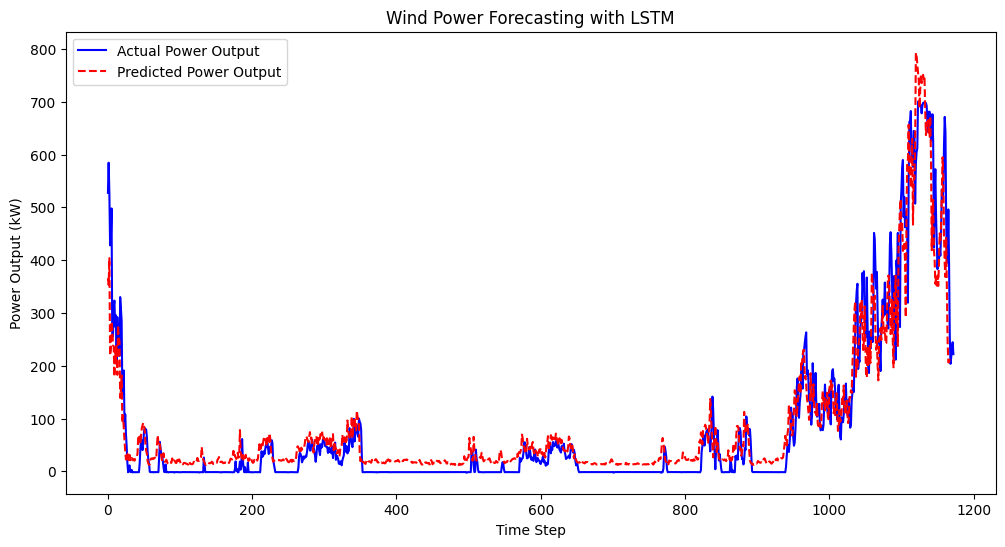

In [49]:
scaler_y_weights = '/home/raghav/TurbineProject/notebooks/minmax_scaler_y.pt'
scaler_y = torch.load(scaler_y_weights)

predictions = scaler_y.inverse_transform(preds)
# predictions = scaler_y.inverse_transform(predictions)
actuals = np.array(df2['Power'])


# Plot predictions vs actuals
plt.figure(figsize=(12,6))
plt.plot(actuals, label="Actual Power Output", color="blue")
plt.plot(predictions, label="Predicted Power Output", color="red", linestyle="dashed")

plt.xlabel("Time Step")
plt.ylabel("Power Output (kW)")
plt.title("Wind Power Forecasting with LSTM")
plt.legend()
plt.show()
